<a href="https://colab.research.google.com/github/AanchalA/PyTorch-Deep-Learning-Bootcamp/blob/main/06_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.4.0+cu121', '0.19.0+cu121')

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 255 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 32.44 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Get Data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Creating Datasets and DataLoaders

## Manually Creating the Transforms
- Creating a manual transform for torchvision.models


In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup



    - All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

    - The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

    You can use the following transform to normalize:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])



In [ ]:
# Images need to have the same mean and std (data distribution) as the ImageNet Dataset
# Mean and standard deviation values for each of the three colour channels.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([transforms.Resize(size=(244, 244)),
                                        transforms.ToTensor(),
                                        normalize])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eb0b4b0b100>,
 ['pizza', 'steak', 'sushi'])

## Using automatically created transforms from the pre-trained model itself (based on the pre-trained model weights.)

In [ ]:
# Getting the pre-trained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT            ## DEFAULT - for the best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create the pre-trained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eb0b4b0af50>,
 ['pizza', 'steak', 'sushi'])

# Loading the Pre-Trained Model

## Old way of loading a pre-trained model

In [ ]:
model = torchvision.models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 56.2MB/s]


## Current way of loading a pre-trained model

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features          ## These layers extract features from images

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.avgpool                   ## This layer converts the features to a feature vector by taking the average.

AdaptiveAvgPool2d(output_size=1)

In [ ]:
# This layer takes in the feature vector and returns logits.
# out_features can be changed as per need.
model.classifier            ## Classifier Head

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## Getting  a summary of the model

In [ ]:
from torchinfo import summary

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_width=20,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Freezing the Base Model + Changing the Output Layer

In [ ]:
# Freezing the base layers (feature extraction layers) of efficientnetB0 Model
for params in model.features.parameters():
    params.requires_grad = False
    # print(params)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# Update the classifier head of the model to suit our use-case
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(in_features=1280, out_features=len(class_names)))        ##3

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_width=20,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Training the model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device
                       )

end_time = timer()
print(f"[INFO] total training time: {end_time-start_time: .2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] total training time:  198.04 seconds


In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

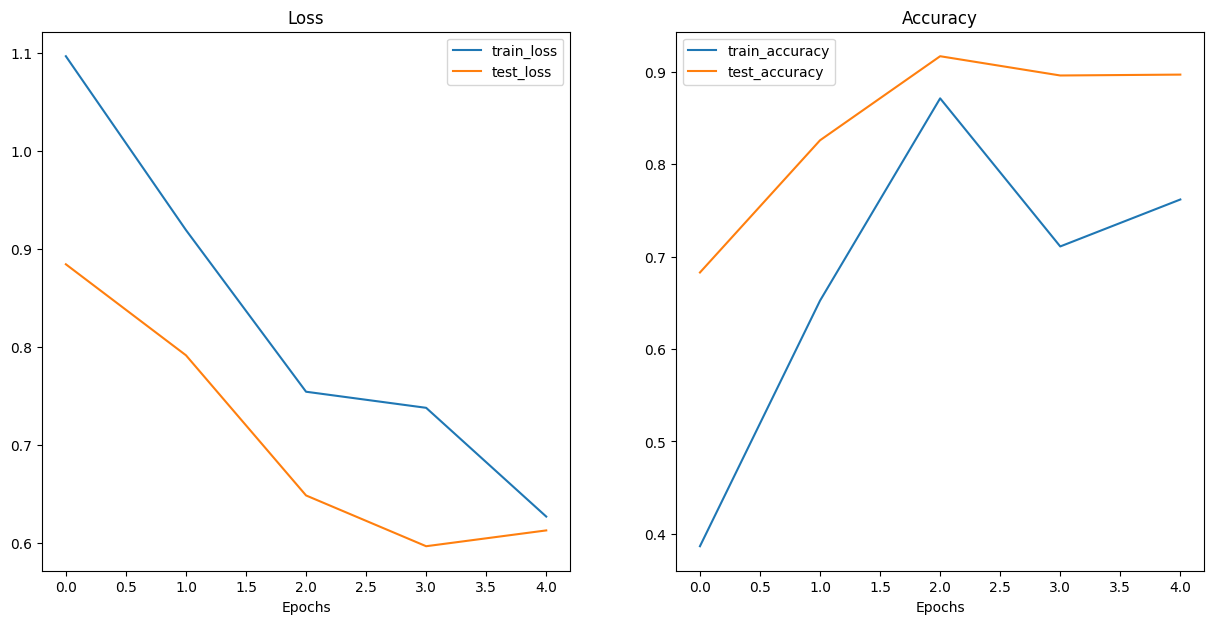

In [ ]:
plot_loss_curves(results)

# Make Predictions

Custom Data Formatting like training data:
- Same Shape
- Same data type
- Same Device
- Same Transform

In [ ]:
from PIL import Image
from typing import List, Tuple
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):

    image = Image.open(image_path)
    if transform:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(size=image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])])
    img = image_transform(image).to(device)

    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        logits = model(img.unsqueeze(dim=0))

    pred_probs = torch.softmax(logits, dim=1)
    pred_index = torch.argmax(pred_probs, dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Class: {class_names[pred_index]} | Prob: {pred_probs.max(): .2f}%")
    plt.axis(False)

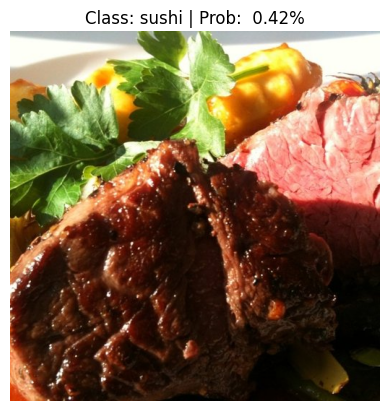

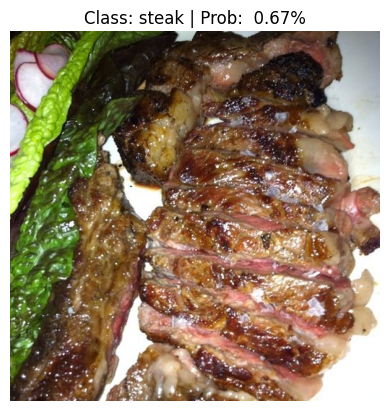

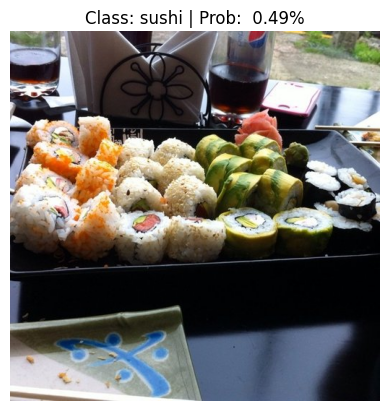

In [ ]:
# Get a random list of image paths from test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

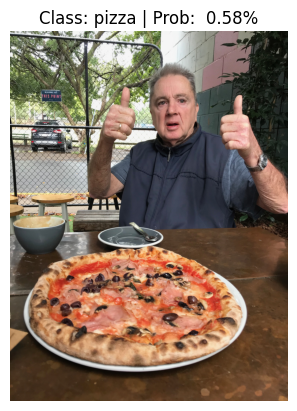

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)